# Inverse design of photonic wavelength division demultiplexer

## Overview
We inverse design a 1x4 wavelength demultiplexer (WDM) in silicon photonics splitting 4 wavelengths spaced 20nm apart into 4 output waveguides. Design region is a 8um x 8um square of silicon surrounded by silica cladding. We use differentiable simulation powered adjoint optimization to aim for high channel transmission while minimizing crosstalk. For sake of speed this is done in 2.5D (differs from 3D by only couple lines in the code).


## Geometry

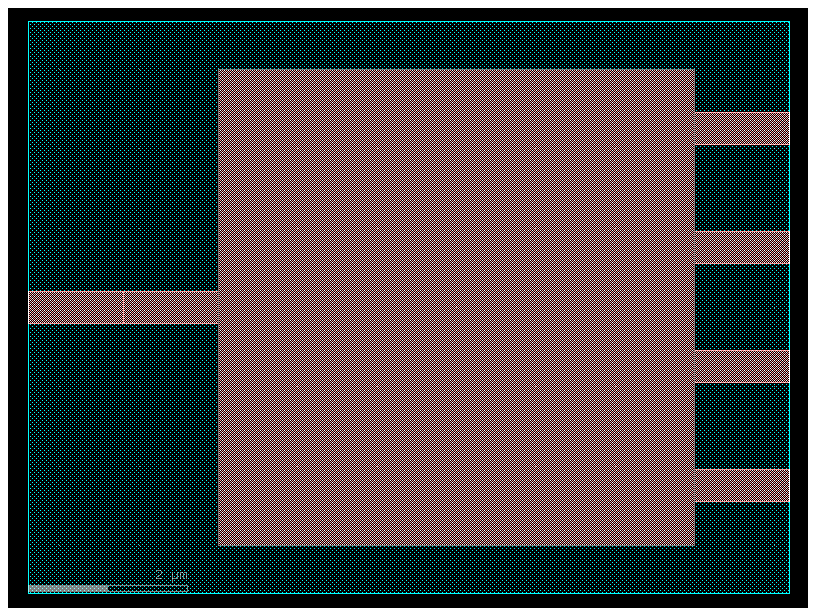

In [30]:
import os
import math
import numpy as np
import luminescent as lumi
import gdsfactory as gf
from gdsfactory.technology import LogicalLayer, LayerLevel, LayerStack
import matplotlib.pyplot as plt
from IPython.display import Image, display


# folder for saving config and results
path = os.path.join("runs", "demux")

wavelength = 1.3  # characteristic wavelength
wavelengths = 1.27, 1.29, 1.31, 1.33

# layers
WG = (1, 0)  # waveguide layer
CLAD = (2, 0)  # cladding layer
DESIGN = (100, 0)  # design region layer

# makes gdsfactory component to be optimized. has rectangular design region with port stubs. ports numbered clockwise from bottom left
length = 6.0
width = 6.0
w_wg = 0.4
l_wg = 3 * w_wg
c = gf.Component()
dut = lumi.mimo(
    length,
    width,
    west=1,
    east=4,
    w_wg=w_wg,
    l_wg=l_wg,
    init=1,  # solid slab
    layer_wg=WG,
    layer_design=DESIGN,
)
# metadata. here we include design region info containing port locations useful for loading the optimized component after optimization
info = {"designs": [{"ports": dut.info.ports}]}
dut = c << dut

# margin extensions
lateral_port_margin = height_port_margin = 0.4
xmargin = 1.5 * lateral_port_margin
zmargin = 1.5 * height_port_margin
source_port_margin = 1.0 * (w_wg + 2 * lateral_port_margin)
ext = c << gf.components.straight(source_port_margin, width=w_wg)
ext.connect("o2", dut.ports["o1"])

# add ports
for i in range(1, 6):
    c.add_port(f"o{i}", port=dut.ports[f"o{i}"])

c << gf.components.bbox(component=c, layer=CLAD, top=xmargin, bottom=xmargin)
c.plot()

## Solve

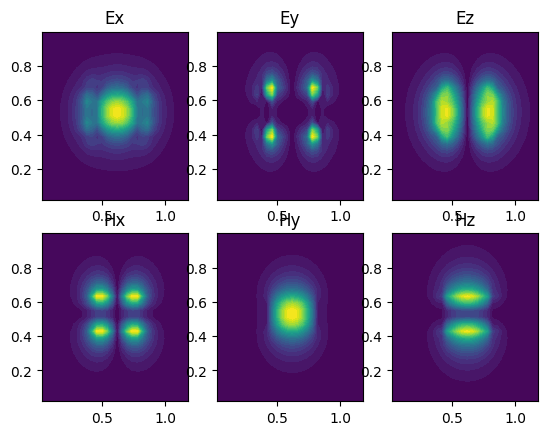

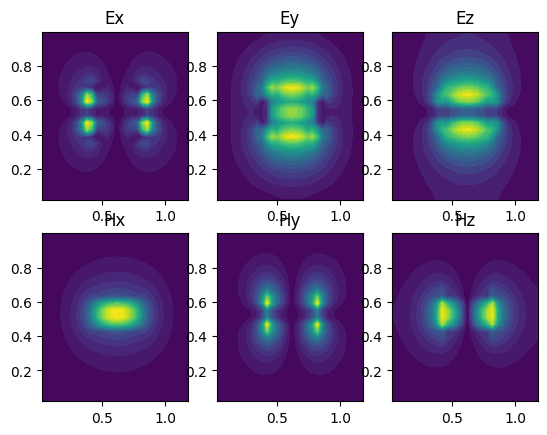

using simulation folder runs\demux


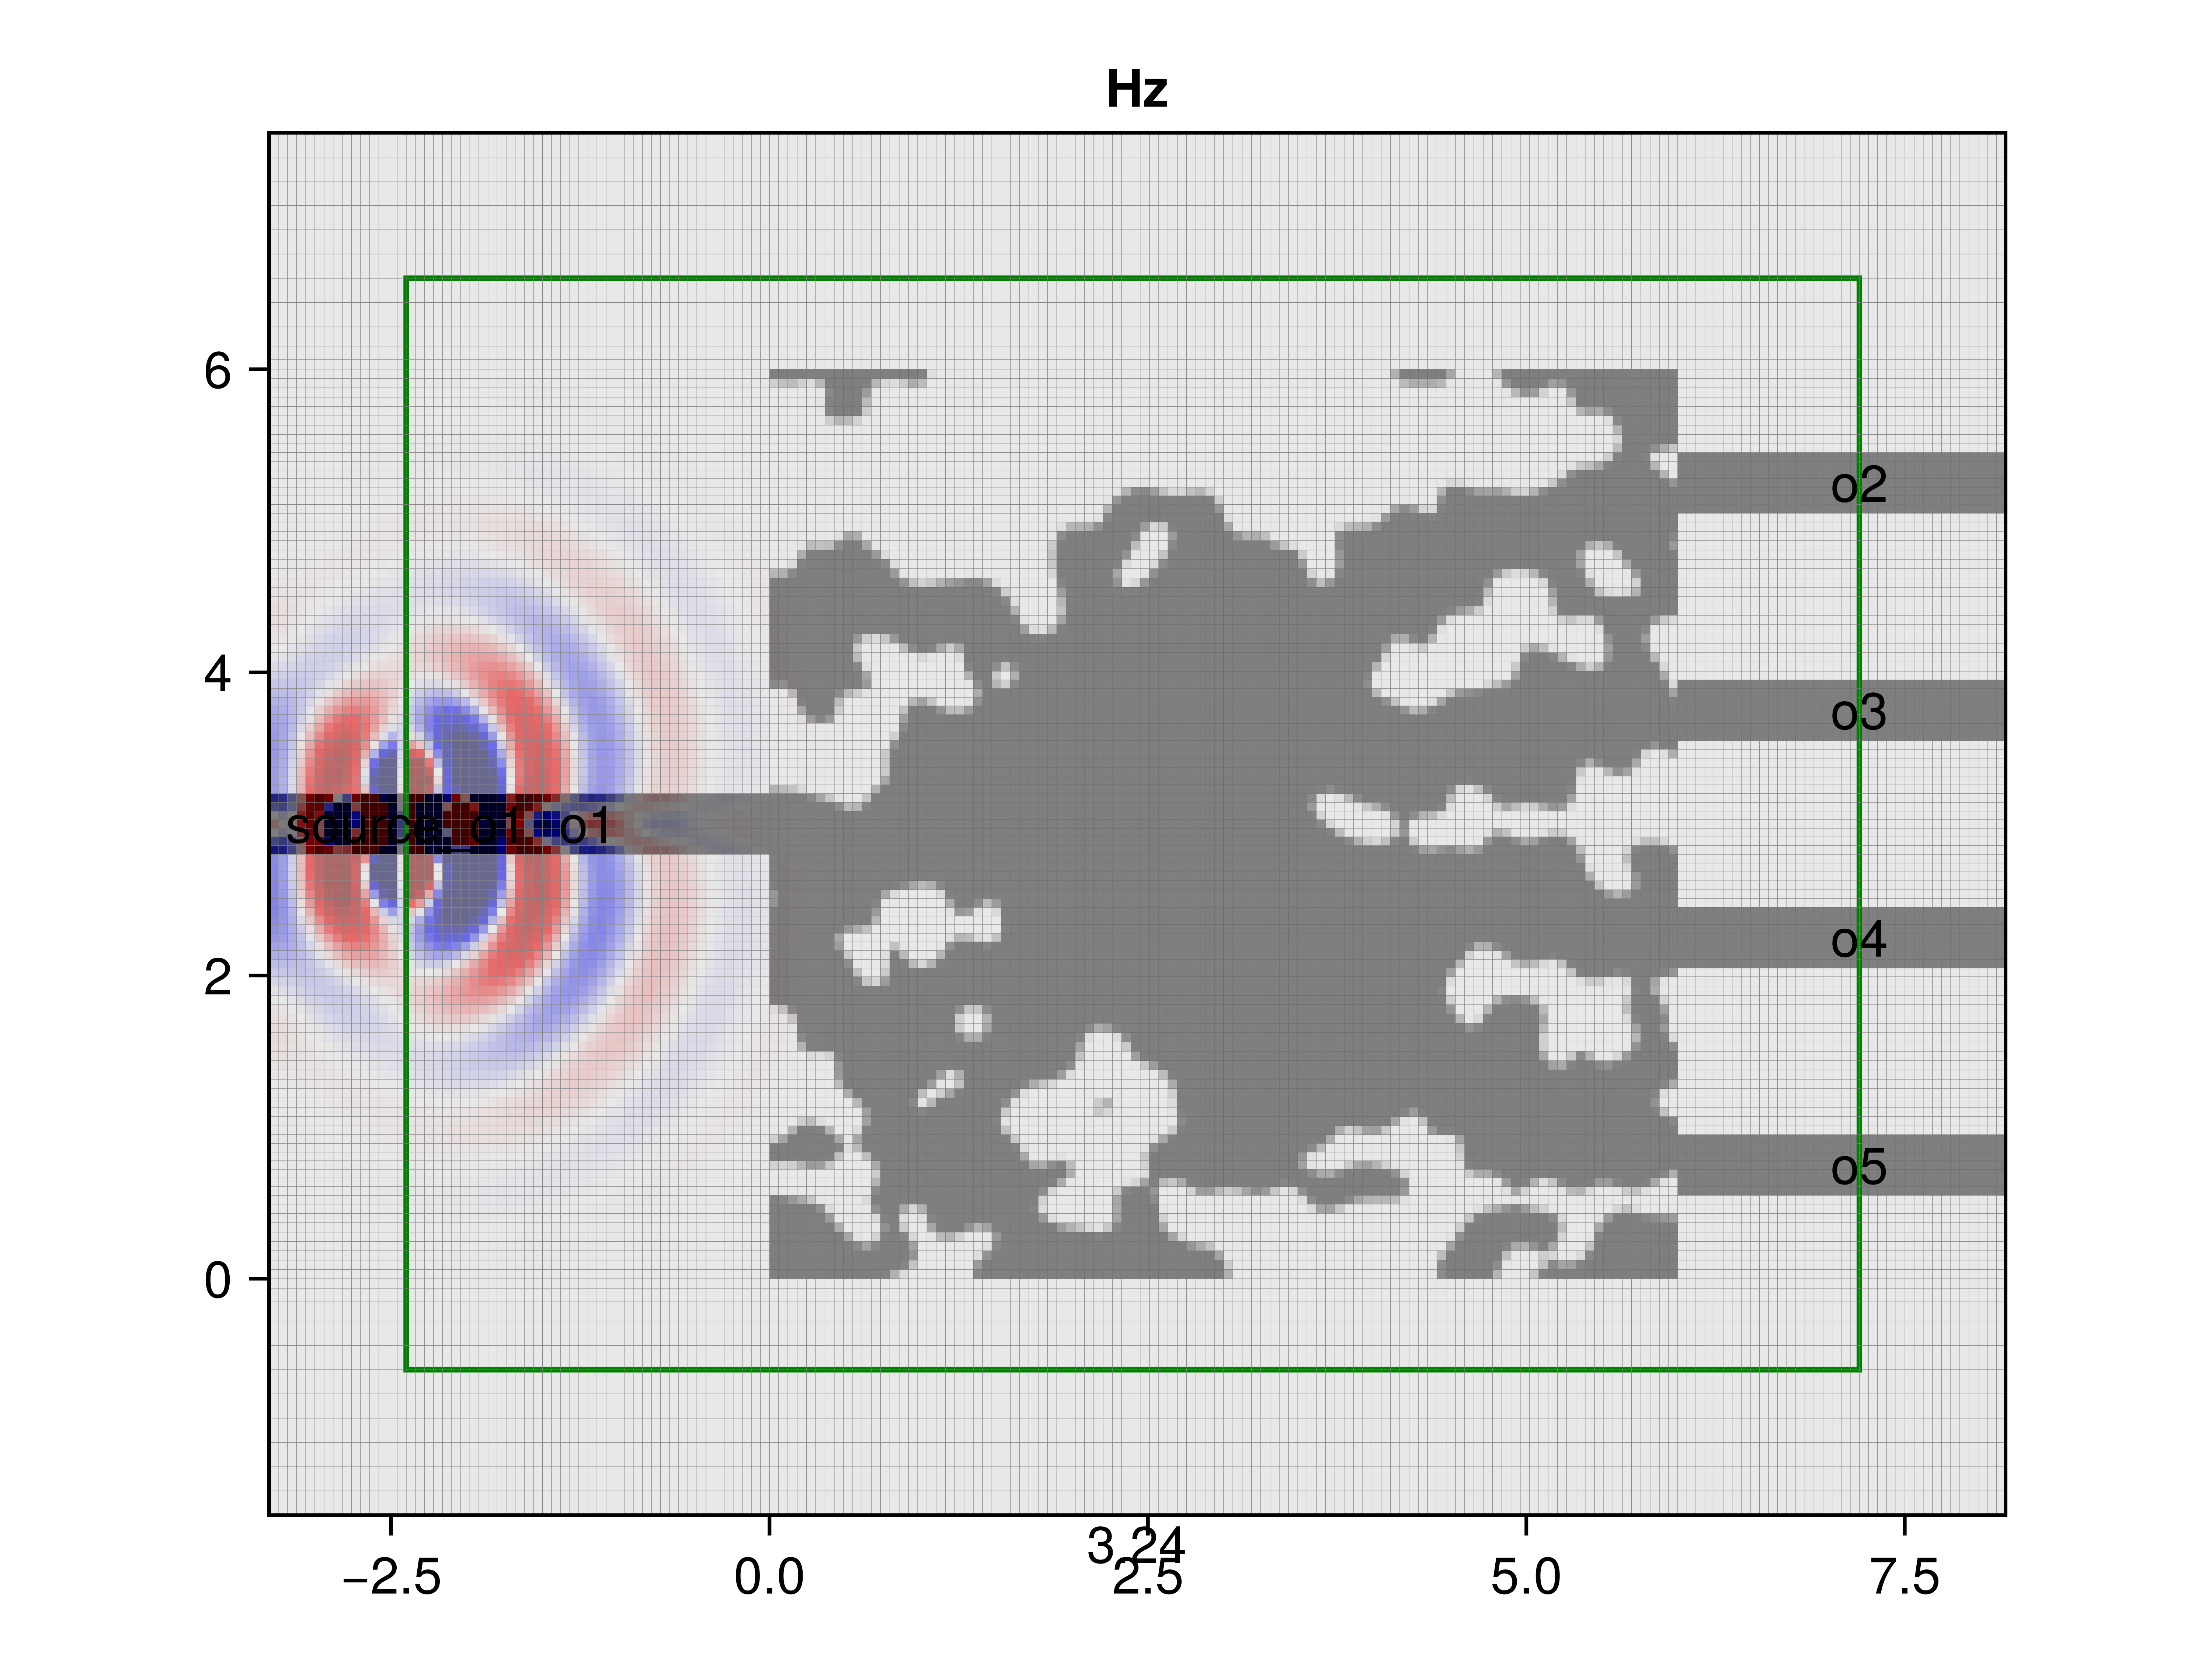

Video generated successfully at runs\demux\simulation.mp4!


< cv2.VideoWriter 000001EEB391FC30>

In [ ]:
# layer stack. lower mesh order layers override higher mesh order layers. for 2.5D problems as is here, the mesher will slice thru middle of 'core' layer
thickness = 0.22
materials_library = lumi.MATERIALS_LIBRARY
nSi = math.sqrt(materials_library["Si"]["epsilon"])
materials_library.update(
    {
        "design": lumi.PlaceholderMaterial(mesh_density=nSi),  # placeholder material for design region
        "background": materials_library["SiO2"],
    }
)

layer_stack = LayerStack(
    layers={
        "design": LayerLevel(
            layer=LogicalLayer(layer=DESIGN),
            thickness=thickness,
            zmin=0.0,
            material="design",
            mesh_order=0,
        ),
        "core": LayerLevel(
            layer=LogicalLayer(layer=WG),
            thickness=thickness,
            zmin=0.0,
            material="Si",
            mesh_order=1,
        ),
    }
)  

# time [periods at characteristic wavelength ]
Tsim = (source_port_margin + 2 * l_wg + 4 * (length + width)) / wavelength * nSi

# each mode will be solved for sources and monitors
modes = [lumi.Mode(wavelength=wavelength)]
sources = [
    lumi.Source(
        "o1",
        source_port_margin=source_port_margin,
        wavelength=wavelength,
        bandwidth=0.2,
    )
]
designs = [
    lumi.Design(
        name="d1",
        layer=DESIGN,
        lmin=0.15,
        fill_material="Si",
        void_material="SiO2",
    )
]
# optimization targets of Tsim params.
# o1@0 means optical port 1 on mode 0 (fundamental mode)
targets = [
    lumi.Target(
        key=f"To{i+2}@0,o1@0",
        target=1.0,
        weight=1 / 4,
        wavelength=wl,
    )
    for i, wl in enumerate(wavelengths)
]

optimizer = lumi.Optimizer(stoploss=0.1, iters=50,momentum=.8)

kwargs = dict(
    path=path,  # path to make problem folder
    component=c,
    wavelengths=wavelengths,
    wavelength=wavelength,
    modes=modes,
    info=info,
    sources=sources,
    #
    lateral_port_margin=lateral_port_margin,
    height_port_margin=height_port_margin,
    zmin=-zmargin,
    zmax=thickness + zmargin,
    #
    materials_library=materials_library,
    layer_stack=layer_stack,
    #
    gpu="CUDA",
    nres=6,  # number of grid points per wavelength in material (not vacuum)
    relative_courant=0.9,
    Tsim=Tsim,
    force=True,  # overwrite files in existing path
    #
    approx_2D_mode="TE",  # makes problem 2.5D instead of 3D
    z=thickness / 2,  # z coordinate to slice the 2.5D problem at
    #
    designs=designs,
    targets=targets,
    optimizer=optimizer,
)
lumi.make(**kwargs)
lumi.solve(path)
display(Image(filename=os.path.join(path, "peak.png")))
lumi.plot(path)

## Post optimization simulation

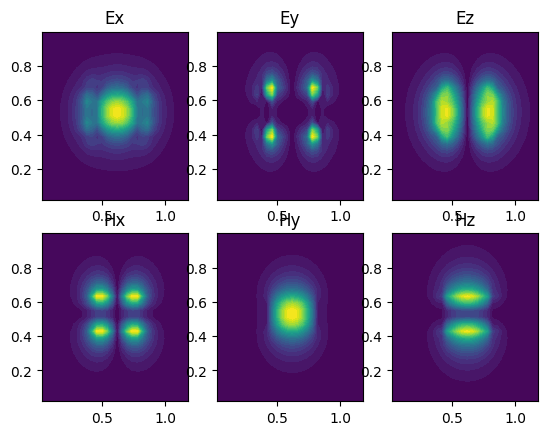

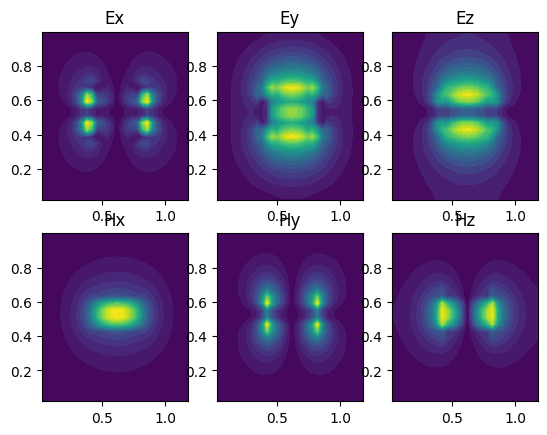

using simulation folder runs\demux


0

In [ ]:
# new simulation with optimized design and finer spaced wavelengths
del kwargs['targets']
del kwargs['optimizer']
wavelengths1=np.linspace(1.26, 1.34, 81)
kwargs.update(
    wavelengths=wavelengths1,
    load_saved_designs=True)
lumi.make(**kwargs)
lumi.solve(path)

loading solution from c:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\runs\demux


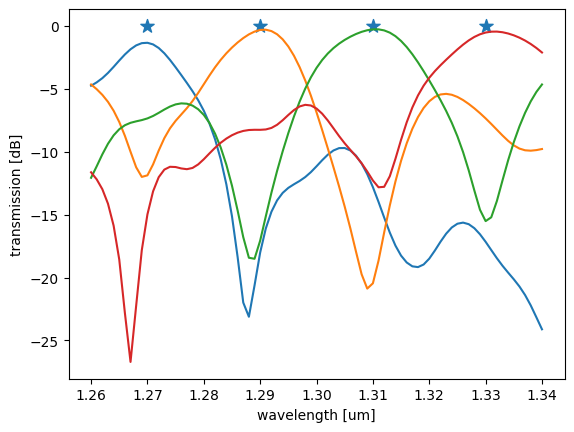

In [ ]:
sol = lumi.load(path)
x = wavelengths1
ys = [lumi.query(sol, f"To{i}@0,o1@0") for i in range(2, 6)]
plt.figure()
for y in ys:
    plt.plot(x, [10*math.log10( y) for y in y])
plt.scatter(wavelengths, [0]*len(wavelengths), 100, marker="*")
plt.xlabel("wavelength [um]")
plt.ylabel("transmission [dB]")
plt.show()